In [ ]:
!pip uninstall -y xgboost -q
!pip install -q xgboost==1.7.6 scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.4 MB/s eta 0:00:00


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())

!nvidia-smi

from google.colab import drive
drive.mount('/content/drive')

import os

PROJECT_ROOT = "/content/drive/MyDrive/TransactIQ"
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data/processed")
CONFIG_PATH = os.path.join(PROJECT_ROOT, "configs", "categories.json")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("CONFIG_PATH:", CONFIG_PATH)


CUDA available: True
Wed Nov 19 11:07:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

In [ ]:
import json

with open(CONFIG_PATH, "r") as f:
    cats_cfg = json.load(f)

id_to_name = {c["id"]: c["name"] for c in cats_cfg["categories"]}
name_to_id = {c["name"]: c["id"] for c in cats_cfg["categories"]}

num_classes = len(id_to_name)
print("Num classes:", num_classes)
print(id_to_name)


Num classes: 10
{0: 'Food & Dining', 1: 'Transportation', 2: 'Shopping & Retail', 3: 'Entertainment & Recreation', 4: 'Healthcare & Medical', 5: 'Utilities & Services', 6: 'Financial Services', 7: 'Income', 8: 'Government & Legal', 9: 'Charity & Donations'}


In [ ]:
from huggingface_hub import login

login(token="<YOUR_API_TOKEN>")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("mitulshah/transaction-categorization")

In [ ]:
train_data = dataset["train"]
len(train_data), train_data[0]

(4501043,
 {'transaction_description': 'Wage',
  'category': 'Income',
  'country': 'USA',
  'currency': 'USD'})

In [ ]:
df = train_data.to_pandas()
df.head()

,transaction_description,category,country,currency
0,Wage,Income,USA,USD
1,Arby's (Contactless),Food & Dining,AUSTRALIA,AUD
2,Occupational Therapy,Healthcare & Medical,USA,USD
3,Potbelly Store Branch,Food & Dining,UK,GBP
4,Amazon - AUSTRALIA,Shopping & Retail,AUSTRALIA,AUD


In [ ]:
from sklearn.model_selection import train_test_split

df["category_id"] = df["category"].map(name_to_id)

train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["category_id"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["category_id"],
    random_state=42
)

y_train = train_df["category_id"].to_numpy()
y_val   = val_df["category_id"].to_numpy()

len(train_df), len(val_df), len(test_df)

(3150730, 675156, 675157)

In [ ]:
proc_dir = os.path.join(PROJECT_ROOT, "data/processed")

# 1️⃣ Extract labels
y_train = train_df["category_id"].to_numpy()
y_val   = val_df["category_id"].to_numpy()
y_test  = test_df["category_id"].to_numpy()

# 2️⃣ Save them
np.save(os.path.join(proc_dir, "y_train.npy"), y_train)
np.save(os.path.join(proc_dir, "y_val.npy"),   y_val)
np.save(os.path.join(proc_dir, "y_test.npy"),  y_test)

print("Saved y_train, y_val, y_test")

Saved y_train, y_val, y_test


In [ ]:
import numpy as np

train_emb_path = os.path.join(PROCESSED_DIR, "train_embeddings.npy")
val_emb_path   = os.path.join(PROCESSED_DIR, "val_embeddings.npy")
test_emb_path  = os.path.join(PROCESSED_DIR, "test_embeddings.npy")

y_train_path = os.path.join(PROCESSED_DIR, "y_train.npy")
y_val_path   = os.path.join(PROCESSED_DIR, "y_val.npy")
y_test_path  = os.path.join(PROCESSED_DIR, "y_test.npy")

# Memory-mapped arrays (read-only)
X_train = np.load(train_emb_path, mmap_mode="r")
X_val   = np.load(val_emb_path,   mmap_mode="r")
X_test  = np.load(test_emb_path,  mmap_mode="r")

y_train = np.load(y_train_path)
y_val   = np.load(y_val_path)
y_test  = np.load(y_test_path)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)


Train: (3150730, 384) (3150730,)
Val: (675156, 384) (675156,)
Test: (675157, 384) (675157,)


In [ ]:
from sklearn.model_selection import train_test_split

MAX_TRAIN = 1_200_000  # tweak if you want

if len(X_train) > MAX_TRAIN:
    idx = np.arange(len(X_train))
    # stratified subset
    sub_idx, _ = train_test_split(
        idx,
        train_size=MAX_TRAIN,
        stratify=y_train,
        random_state=42
    )
    X_train_sub = X_train[sub_idx]
    y_train_sub = y_train[sub_idx]
    print("Using subset:", X_train_sub.shape, y_train_sub.shape)
else:
    X_train_sub = X_train
    y_train_sub = y_train
    print("Using full training set.")


Using subset: (1200000, 384) (1200000,)


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

print("XGBoost version:", xgb.__version__)

dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval   = xgb.DMatrix(X_val,       label=y_val)

params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "max_depth": 8,
    "eta": 0.2,
    "tree_method": "gpu_hist",      # GPU in XGBoost 1.7.6
    "predictor": "gpu_predictor",   # GPU predictor
    "eval_metric": "mlogloss",
}

evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=250,
    evals=[(dtrain, "train"), (dval, "val")],
    evals_result=evals_result,
    verbose_eval=25,
)

XGBoost version: 1.7.6
[0]	train-mlogloss:1.77446	val-mlogloss:1.77880
[25]	train-mlogloss:0.15513	val-mlogloss:0.17297
[50]	train-mlogloss:0.04864	val-mlogloss:0.06418
[75]	train-mlogloss:0.02688	val-mlogloss:0.04010
[100]	train-mlogloss:0.02000	val-mlogloss:0.03195
[125]	train-mlogloss:0.01713	val-mlogloss:0.02854
[150]	train-mlogloss:0.01547	val-mlogloss:0.02679
[175]	train-mlogloss:0.01451	val-mlogloss:0.02585
[200]	train-mlogloss:0.01389	val-mlogloss:0.02530
[225]	train-mlogloss:0.01346	val-mlogloss:0.02498
[249]	train-mlogloss:0.01317	val-mlogloss:0.02481


In [ ]:
import json
import os

CONFIG_PATH = os.path.join(PROJECT_ROOT, "configs", "categories.json")

with open(CONFIG_PATH, "r") as f:
    cats_cfg = json.load(f)

id_to_name = {c["id"]: c["name"] for c in cats_cfg["categories"]}
name_to_id = {c["name"]: c["id"] for c in cats_cfg["categories"]}

num_classes = len(id_to_name)
print("Classes:", num_classes)
print(id_to_name)

Classes: 10
{0: 'Food & Dining', 1: 'Transportation', 2: 'Shopping & Retail', 3: 'Entertainment & Recreation', 4: 'Healthcare & Medical', 5: 'Utilities & Services', 6: 'Financial Services', 7: 'Income', 8: 'Government & Legal', 9: 'Charity & Donations'}


In [ ]:
target_names = [id_to_name[i] for i in range(num_classes)]
print(target_names)

['Food & Dining', 'Transportation', 'Shopping & Retail', 'Entertainment & Recreation', 'Healthcare & Medical', 'Utilities & Services', 'Financial Services', 'Income', 'Government & Legal', 'Charity & Donations']


============ Validation Results ============
                            precision    recall  f1-score   support

             Food & Dining     0.9934    0.9882    0.9908     67189
            Transportation     0.9938    0.9851    0.9894     67385
         Shopping & Retail     0.9518    0.9513    0.9516     67491
Entertainment & Recreation     1.0000    0.9999    0.9999     67425
      Healthcare & Medical     0.9655    0.9748    0.9701     67478
      Utilities & Services     0.9856    0.9940    0.9898     67776
        Financial Services     0.9994    0.9996    0.9995     67644
                    Income     0.9854    0.9929    0.9891     67582
        Government & Legal     0.9847    0.9739    0.9793     67666
       Charity & Donations     0.9999    0.9998    0.9999     67520

                  accuracy                         0.9859    675156
                 macro avg     0.9860    0.9859    0.9859    675156
              weighted avg     0.9860    0.9859    0.9859    675156



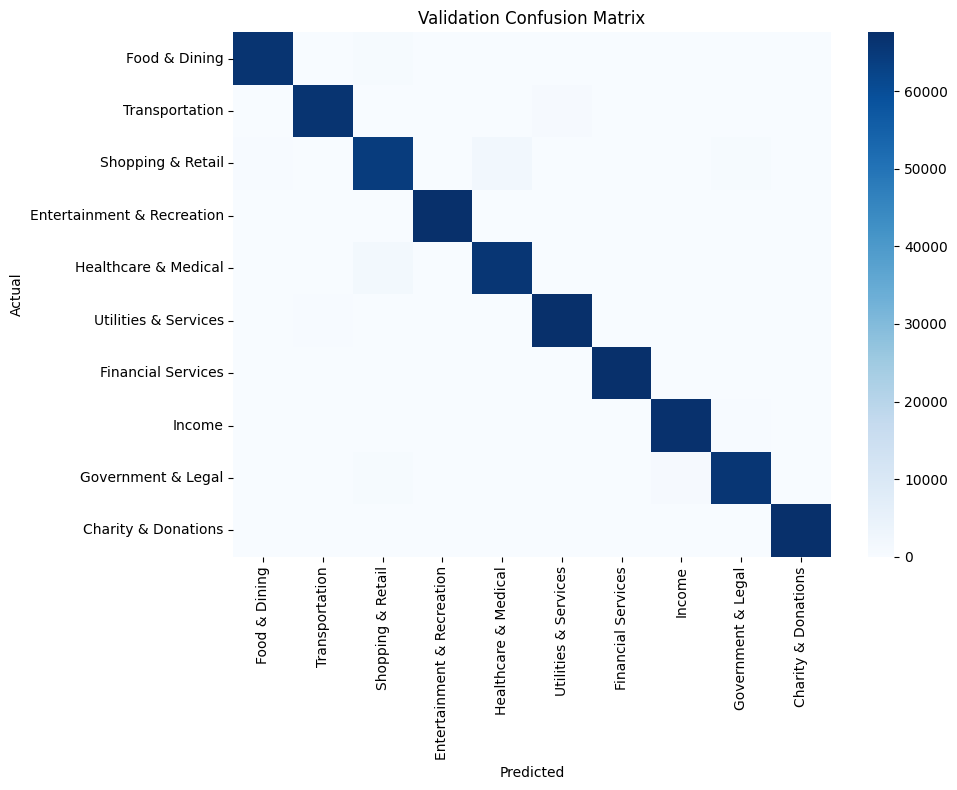

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# VALIDATION METRICS
# --------------------------
print("============ Validation Results ============")

# Class predictions
y_val_proba = bst.predict(xgb.DMatrix(X_val))
y_val_pred  = y_val_proba.argmax(axis=1)

# Classification report
print(classification_report(
    y_val,
    y_val_pred,
    digits=4,
    target_names=target_names
))

# F1 Scores
macro_f1_val = f1_score(y_val, y_val_pred, average='macro')
weighted_f1_val = f1_score(y_val, y_val_pred, average='weighted')
per_class_f1_val = f1_score(y_val, y_val_pred, average=None)

print("Validation Macro F1:", macro_f1_val)
print("Validation Weighted F1:", weighted_f1_val)
print("Validation Per-class F1:", per_class_f1_val)

# Confusion Matrix (Validation)
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, cmap="Blues", annot=False, xticklabels=target_names, yticklabels=target_names)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


============ Test Results ============
                            precision    recall  f1-score   support

             Food & Dining     0.9931    0.9888    0.9910     67189
            Transportation     0.9944    0.9861    0.9903     67385
         Shopping & Retail     0.9527    0.9493    0.9510     67491
Entertainment & Recreation     1.0000    0.9997    0.9999     67424
      Healthcare & Medical     0.9653    0.9754    0.9703     67479
      Utilities & Services     0.9864    0.9946    0.9905     67777
        Financial Services     0.9994    0.9996    0.9995     67644
                    Income     0.9861    0.9927    0.9894     67582
        Government & Legal     0.9831    0.9745    0.9788     67666
       Charity & Donations     1.0000    0.9996    0.9998     67520

                  accuracy                         0.9860    675157
                 macro avg     0.9861    0.9860    0.9860    675157
              weighted avg     0.9861    0.9860    0.9860    675157

Test 

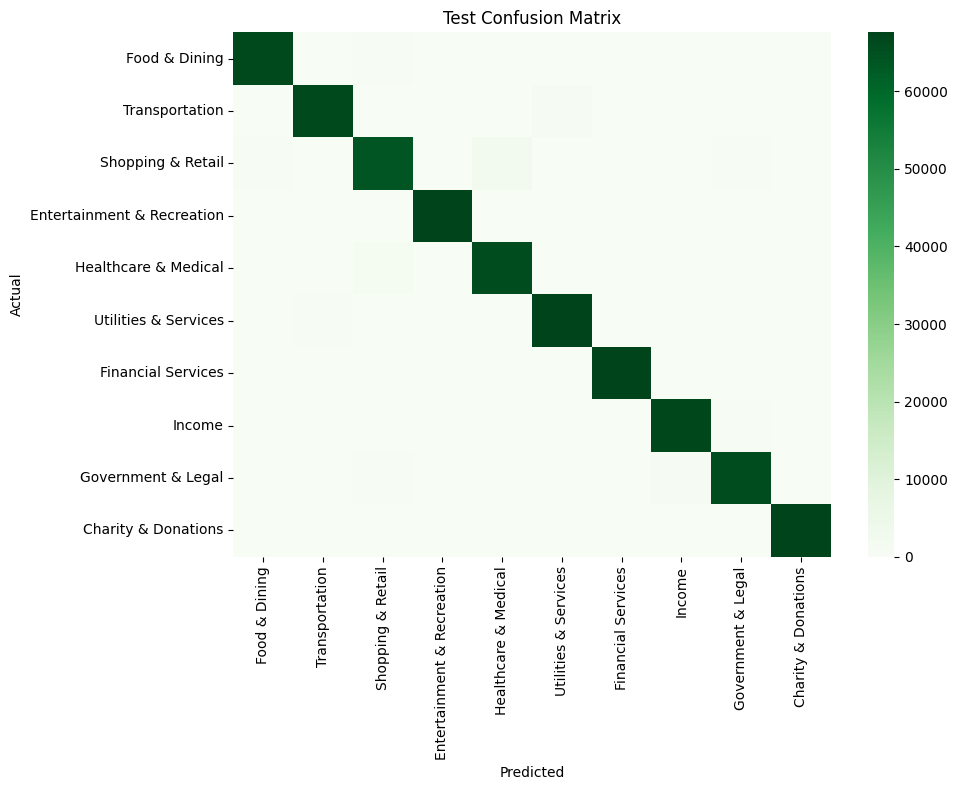

In [ ]:
print("\n============ Test Results ============")

# Class predictions
dtest = xgb.DMatrix(X_test, label=y_test)
y_test_proba = bst.predict(dtest)
y_test_pred  = y_test_proba.argmax(axis=1)

# Classification report
print(classification_report(
    y_test,
    y_test_pred,
    digits=4,
    target_names=target_names
))

# F1 Scores
macro_f1_test = f1_score(y_test, y_test_pred, average='macro')
weighted_f1_test = f1_score(y_test, y_test_pred, average='weighted')
per_class_f1_test = f1_score(y_test, y_test_pred, average=None)

print("Test Macro F1:", macro_f1_test)
print("Test Weighted F1:", weighted_f1_test)
print("Test Per-class F1:", per_class_f1_test)

# Confusion Matrix (Test)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, cmap="Greens", annot=False, xticklabels=target_names, yticklabels=target_names)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
model_path = os.path.join(PROJECT_ROOT, "models", "xgb_emb_classifier.json")
bst.save_model(model_path)
print("Saved model to:", model_path)

Saved model to: /content/drive/MyDrive/TransactIQ/models/xgb_emb_classifier.json
